In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import shutil

In [119]:
# SET GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
IMG_SIZE = 300
SEED = 123

206 280 130 153
7 297 133 175
765 271 138 132
205 272 128 156
806 263 81 124
644 361 327 354
46 262 85 157
347 255 63 124
113 251 49 142
229 246 87 164
500 232 34 103
400 247 90 112
453 249 48 85


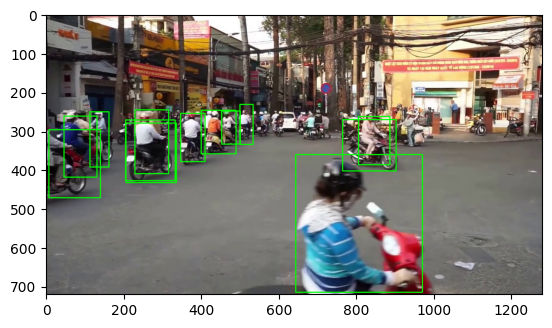

: 

In [15]:
def load_image_box(img_path, forder_box):

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load boxes
    file_boxes = os.path.join(forder_box, os.path.basename(img_path).split(".")[0] + ".txt")
    with open(file_boxes, "r") as f:
        lines = f.readlines()
    box = np.zeros((len(lines), 5))
    for i, line in enumerate(lines):
        box[i] = np.array(line.split(" ")).astype(np.float32) # [class x y w h]

    return img, box

img, box = load_image_box("dataset_final/images/motorbike_internet04_002988.jpg", "dataset_final/labels_yolo/")
# get shape image
height, width, _ = img.shape
for i in range(len(box)):
    x = int((box[i][1] - box[i][3]/2)*width)
    y = int((box[i][2] - box[i][4]/2)*height)
    w = int(box[i][3]*width)
    h = int(box[i][4]*height)

    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(img)

In [121]:
# read file xml
def read_xml(file):

    tree = ET.parse(file)
    root = tree.getroot()

    size = root.find("size")
    size = [int(size.find("width").text), int(size.find("height").text)]

    names = []
    boxes = []
    for obj in root.findall("object"):
        bndbox = obj.find("bndbox")
        name = obj.find("name").text
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
        names.append(name)

    return size, names, boxes

# Convert Pascal/VOC to YOLO format
def convert(size, box):
    dw = 1.0 / (size[0])
    dh = 1.0 / (size[1])
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

In [122]:
# file_data = "data/data.csv"

# data = pd.read_csv(file_data)
# data = data.to_numpy()

# X_data = []
# labels = []
# i=0

# for d in data:
#     try:
#         boxes = read_xml(d[1])
#         X_data.append(d[0])
#         labels.append(boxes)
#         i+=1
#         if i%100==0:
#             print(i)
#     except:
#         pass

# X_data = np.array(X_data)
# labels = np.array(labels)

# np.save("data/X_data.npy", X_data)
# np.save("data/labels.npy", labels)

In [123]:
X_data = np.load("data/X_data.npy")
labels = np.load("data/labels.npy", allow_pickle=True)

folder_label = "dataset/labels_yolo/"

In [124]:
# if not os.path.exists(folder_label):
#     os.makedirs(folder_label)

# # Delete all file in folder_label
# for filename in os.listdir(folder_label):
#     os.remove(folder_label + filename)

In [125]:
# Create labels
def create_label(file, size, names, boxes, classes):
    file_label = open(file, "w")
    for i in range(len(names)):
        name = names[i]
        box = boxes[i]
        box = convert(size, box)
        file_label.write(str(classes.tolist().index(name))+" "+" ".join(["{:.5f}".format(a) for a in box])+"\n")
    file_label.close()

In [126]:
# # Create classes.txt
# classes= np.unique(np.concatenate(labels[:,1]))
# open("data/classes.txt", "w").write("\n".join(classes))

# for i in range(len(X_data)):
#     file_name = X_data[i].split("/")[-1].split(".")[0]
#     size, names, boxes = labels[i]
#     create_label(folder_label+file_name+".txt", size, names, boxes, classes)


In [127]:
# Statistics number images in each class
def statistics_class(labels):
    classes = np.unique(np.concatenate(labels[:,1]))
    count = np.zeros(len(classes))
    for i in range(len(classes)):
        for j in range(len(labels)):
            if classes[i] in labels[j][1]:
                count[i]+=1
    return classes, count


In [128]:
# # Get data classes car, person, bus, motorbike and write labels

# def get_data_class(X_data, labels, classes):
#     X_data_class = []
#     labels_class = []
#     for i in range(len(X_data)):
#         if any(item in classes for item in labels[i][1]):
#             X_data_class.append(X_data[i])
#             for j in range(len(labels[i][1])):
#                 if labels[i][1][j] in classes:
#                     if len(labels_class) < len(X_data_class):
#                         labels_class.append([labels[i][0], [labels[i][1][j]], [labels[i][2][j]]])
#                     else:
#                         labels_class[-1][1].append(labels[i][1][j])
#                         labels_class[-1][2].append(labels[i][2][j])
#     return X_data_class, labels_class

# classes = ["car", "person", "bus", "motorbike"]
# classes = np.array(classes)
# X_data_class, labels_class = get_data_class(X_data, labels, classes)
# print(len(X_data_class), len(labels_class))

# folder_dataset_final = "dataset_final/"
# folder_label_final = folder_dataset_final+"labels_yolo/"
# folder_image_final = folder_dataset_final+"images/"

# if not os.path.exists(folder_dataset_final):
#     os.makedirs(folder_dataset_final)
# if not os.path.exists(folder_label_final):
#     os.makedirs(folder_label_final)
# if not os.path.exists(folder_image_final):
#     os.makedirs(folder_image_final)

# for i in range(len(X_data_class)):
#     file_name = X_data_class[i].split("/")[-1].split(".")[0]
#     size, names, boxes = labels_class[i]
#     create_label(folder_label_final+file_name+".txt", size, names, boxes, classes)
#     shutil.copy(X_data_class[i], folder_image_final+file_name+".jpg")

# np.save("data/X_data_class.npy", X_data_class)
# np.save("data/labels_class.npy", np.array(labels_class))

97848 97848


C:\Users\chiho\AppData\Local\Temp\ipykernel_29288\1379077228.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save("data/labels_class.npy", np.array(labels_class))


In [129]:
# with open("data/obj.names", "w") as f:
#     f.write("car\nperson\nbus\nmotorbike")

In [130]:
X_data_class = np.load("data/X_data_class.npy")
labels_class = np.load("data/labels_class.npy", allow_pickle=True)

(array(['bus', 'car', 'motorbike', 'person'], dtype='<U9'),
 array([59851., 44590., 13571., 46076.]))

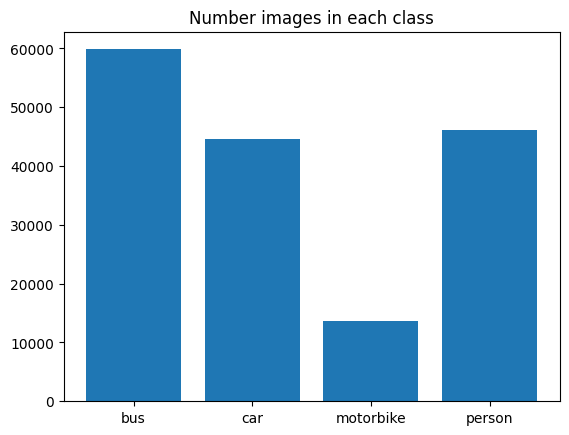

In [131]:
classes, count = statistics_class(labels_class)
plt.title("Number images in each class")
plt.bar(classes, count)
classes, count

(array(['bus', 'car', 'motorbike', 'person'], dtype='<U9'),
 array([ 71495., 121856.,  31952., 110093.]))

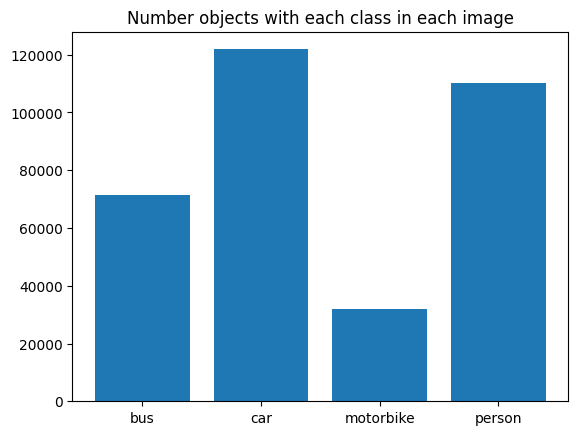

In [132]:
# statistics number objects with each class in each image
def statistics_object_image(labels):
    classes = np.unique(np.concatenate(labels[:,1]))
    count = np.zeros(len(classes))
    for i in range(len(classes)):
        for j in range(len(labels)):
            if classes[i] in labels[j][1]:
                count[i] += labels[j][1].count(classes[i])
    return classes, count
classes, count = statistics_object_image(labels_class)
plt.title("Number objects with each class in each image")
plt.bar(classes, count)
classes, count

In [133]:
# Number object in each class in each image
def statistics_objects_images(labels_class, classes):
    objects_images = []
    for i in range(len(labels_class)):
        classes_image = np.unique(labels_class[i][1])
        objects_image = np.zeros(len(classes))
        for j in range(len(classes)):
            if classes[j] in classes_image:
                objects_image[j] = np.sum(np.array(labels_class[i][1])==classes[j])
        objects_images.append(objects_image)
    objects_images = pd.DataFrame(objects_images, columns=classes)
    return objects_images

In [134]:
# Split data to train, test, val prioritize classes have a few objects
def split_data(X_data, labels, classes, objects_images, raito):
    X_data_train = []
    labels_train = []
    X_data_test = []
    labels_test = []
    X_data_val = []
    labels_val = []

    index_data = []
    for i in range(len(classes)):
        num_object = np.unique(objects_images[classes[i]])
        for j in range(len(num_object)):
            index = np.where((objects_images[classes[i]]==num_object[j]) & (objects_images[classes[i]]>0))[0]
            # Get index have not in index_data
            index = np.setdiff1d(index, index_data)
            index_data = np.concatenate((index_data, index))
            if len(index) == 0:
                continue
            # random with seed
            np.random.seed(SEED)
            np.random.shuffle(index)
            num_train = int(len(index)*raito[0])
            num_test = int(len(index)*raito[1])
            num_val = len(index) - num_train - num_test
            X_data_train.extend(X_data[index[:num_train]])
            labels_train.extend(labels[index[:num_train]])
            if num_test > 0:
                X_data_test.extend(X_data[index[num_train:num_train+num_test]])
                labels_test.extend(labels[index[num_train:num_train+num_test]])
            if num_val > 0 and raito[2] > 0:
                X_data_val.extend(X_data[index[num_train+num_test:]])
                labels_val.extend(labels[index[num_train+num_test:]])

    X_data_train = np.array(X_data_train)
    labels_train = np.array(labels_train)
    X_data_test = np.array(X_data_test)
    labels_test = np.array(labels_test)
    X_data_val = np.array(X_data_val)
    labels_val = np.array(labels_val)
    return X_data_train, labels_train, X_data_test, labels_test, X_data_val, labels_val

In [135]:
def split_data_use(X_data, labels, classes, objects_images, num_images_use):
    X_data_use = []
    labels_use = []
    X_data_not_use = []
    labels_not_use = []

    index_data = []
    for i in range(len(classes)):
        num_object = np.unique(objects_images[classes[i]])
        for j in range(len(num_object)):
            index = np.where((objects_images[classes[i]]==num_object[j]) & (objects_images[classes[i]]>0))[0]
            # Get index have not in index_data
            index = np.setdiff1d(index, index_data)
            index_data = np.concatenate((index_data, index))
            if len(index) == 0:
                continue
            # random with seed
            np.random.seed(SEED)
            np.random.shuffle(index)
            num_use = min(len(index), num_images_use)
            X_data_use.extend(X_data[index[:num_use]])
            labels_use.extend(labels[index[:num_use]])
            X_data_not_use.extend(X_data[index[num_use:]])
            labels_not_use.extend(labels[index[num_use:]])

    X_data_use = np.array(X_data_use)
    labels_use = np.array(labels_use)
    X_data_not_use = np.array(X_data_not_use)
    labels_not_use = np.array(labels_not_use)
    return X_data_use, labels_use, X_data_not_use, labels_not_use

In [136]:
# Write X_data to file
def write_data(X_data, file_name, folder):
    with open(file_name, "w") as f:
        for i in range(len(X_data)):
            file_name = folder + X_data[i].split("/")[-1]
            f.write(file_name+("\n" if i!=len(X_data)-1 else ""))

In [137]:
# # Copy images and labels to folder_images_labels
# folder_image_label = "dataset_final/images_labels/"
# if not os.path.exists(folder_image_label):
#     os.makedirs(folder_image_label)
# # for file_name in os.listdir(folder_image_label):
# #     os.remove(folder_image_label+file_name)

# objects_images = statistics_objects_images(labels_class, classes)
# X_data_use, labels_use, X_data_not_use, labels_not_use = split_data_use(X_data_class, labels_class, classes, objects_images, 10000)
# X_data_final = []
# labels_final = []
# for i in range(len(X_data_use)):
#     file_name = X_data_use[i].split("/")[-1].split(".")[0]
#     #shutil.copy(X_data_use[i], folder_image_label+file_name+".jpg")
#     shutil.copy("dataset_final/labels_yolo/"+file_name+".txt", folder_image_label+file_name+".txt")
#     X_data_final.append(folder_image_label+file_name+".jpg")
#     labels_final.append(labels_use[i])

# X_data_final = np.array(X_data_final)
# labels_final = np.array(labels_final)

# np.save("data/X_data_final.npy", X_data_final)
# np.save("data/labels_final.npy", labels_final)

In [138]:
X_data_final = np.load("data/X_data_final.npy")
labels_final = np.load("data/labels_final.npy", allow_pickle=True)

classes_final, counts_final = statistics_class(labels_final)
objects_images_final = statistics_objects_images(labels_final, classes)
classes_objects_final, counts_objects_final  = statistics_object_image(labels_final)

print("classes_final: ", classes_final)
print("counts_final: ", counts_final)

print("classes_objects_final: ", classes_objects_final)
print("counts_objects_final: ", counts_objects_final)

classes_final:  ['bus' 'car' 'motorbike' 'person']
counts_final:  [19869. 27583. 10498. 32939.]
classes_objects_final:  ['bus' 'car' 'motorbike' 'person']
counts_objects_final:  [31513. 88908. 25793. 82241.]


(array([0.50436328, 0.24853781, 0.32512697, 0.31975535]),
 array([15894., 22097.,  8386., 26297.]))

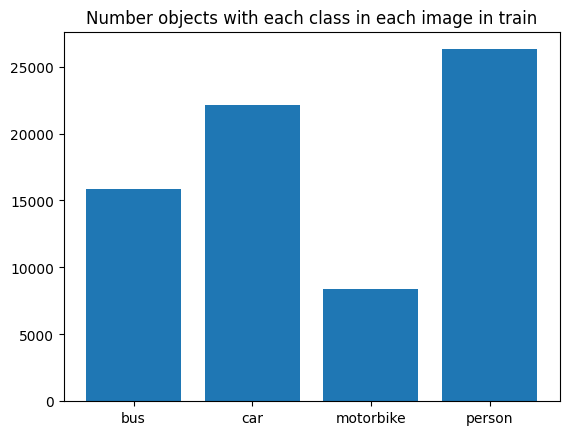

In [139]:
# Sort classes have a few objects
index_sort = np.argsort(np.sum(objects_images_final, axis=0))
classes_final = classes_final[index_sort]

raito = [0.8, 0.1, 0.1]
X_data_train, labels_train, X_data_test, labels_test, X_data_val, labels_val = split_data(X_data_final, labels_final, classes, objects_images_final, raito)

classes_train, count_train = statistics_class(labels_train)
plt.title("Number objects with each class in each image in train")
plt.bar(classes_train, count_train)
count_train/counts_objects_final, count_train

In [140]:
# write_data(X_data_train, "data/train.txt", "/mylaptop/images_labels/")
# write_data(X_data_test, "data/test.txt", "/mylaptop/images_labels/")
# write_data(X_data_val, "data/val.txt", "/mylaptop/images_labels/")